In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


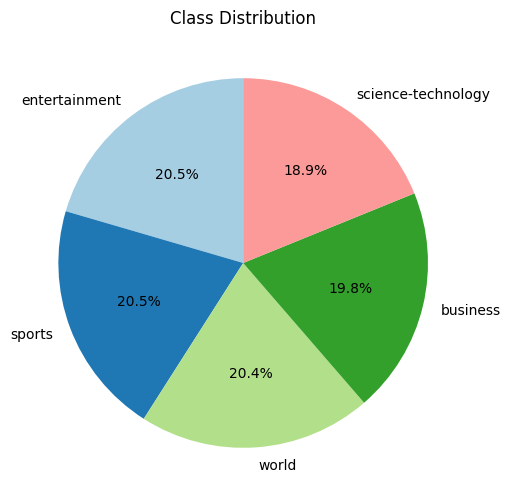

In [2]:
df = pd.read_csv('tokenized_news_articles.csv')

X = df['tokenized_content']  
y = df['gold_label'] 

class_counts = y.value_counts()

plt.figure(figsize=(8, 6))
class_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title("Class Distribution")
plt.ylabel("")  
plt.show()

label_to_index = {label: idx for idx, label in enumerate(y.unique())}
index_to_label = {idx: label for label, idx in label_to_index.items()}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32, stratify=y)


In [3]:
all_tokens = [token for tokens in X for token in eval(tokens)]  # Use eval if stored as strings
vocabulary = list(set(all_tokens))
token_to_index = {token: idx for idx, token in enumerate(vocabulary)}
vocab_size = len(vocabulary)

def tokens_to_vector(tokens, token_to_index, vocab_size):
    vector = np.zeros(vocab_size)
    for token in eval(tokens):  # Use eval if tokens are stored as strings in CSV
        if token in token_to_index:
            vector[token_to_index[token]] += 1
    return vector

# Convert tokenized content into feature matrices
X_train_vectors = np.array([tokens_to_vector(tokens, token_to_index, vocab_size) for tokens in X_train])
X_test_vectors = np.array([tokens_to_vector(tokens, token_to_index, vocab_size) for tokens in X_test])

In [4]:

X_train_tfidf = X_train_vectors
X_test_tfidf = X_test_vectors

y_train_encoded = y_train.map(label_to_index).to_numpy()
y_test_encoded = y_test.map(label_to_index).to_numpy()


In [5]:
class MultinomialNaiveBayes:
    
    def __init__(self):
          
        self.class_priors = {}   # To contain class priors
        self.likelihoods = {}  # To store likelihoods of each word in each class
        self.number_features = 0   # To store number of features
        self.unique_classes = []  # To store the number of unique classes

    def fit(self, feature_matrix, y_target):
        
        # feature_matrix will be the feature matrix and y_target will be the target vector
        
        self.unique_classes = np.unique(y_target)
        num_samples, num_words = feature_matrix.shape
        self.number_features = num_words 
        word_counts_class = {}
        total_class = {}

        for object in self.unique_classes:
            
            X_filtered = feature_matrix[y_target == object]
            
            total_class[object] = X_filtered.shape[0]
            
            word_counts_class[object] = np.sum(X_filtered, axis=0)
            
            self.class_priors[object] = np.log(total_class[object] / num_samples)
            
            total_word_class = np.sum(word_counts_class[object])
            self.likelihoods[object] = np.log((word_counts_class[object] + 1) / 
                                                     (total_word_class + self.number_features))
            
    def predict(self, feature_matrix):
        
        predicted_value = []

        for i in feature_matrix:
            scores = {}
            for j in self.unique_classes:
                scores[j] = self.class_priors[j]
                scores[j] = scores[j] + np.sum(i * self.likelihoods[j])
            best_class = max(scores, key=scores.get)
            predicted_value.append(best_class)

        return np.array(predicted_value)


Accuracy: 0.9601139601139601
Precision: 0.9603509438161184
Recall: 0.9601139601139601
F1 Score: 0.9601938492116536

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        72
           1       0.96      0.97      0.96        69
           2       0.99      0.97      0.98        72
           3       0.94      0.94      0.94        66
           4       0.93      0.94      0.94        72

    accuracy                           0.96       351
   macro avg       0.96      0.96      0.96       351
weighted avg       0.96      0.96      0.96       351



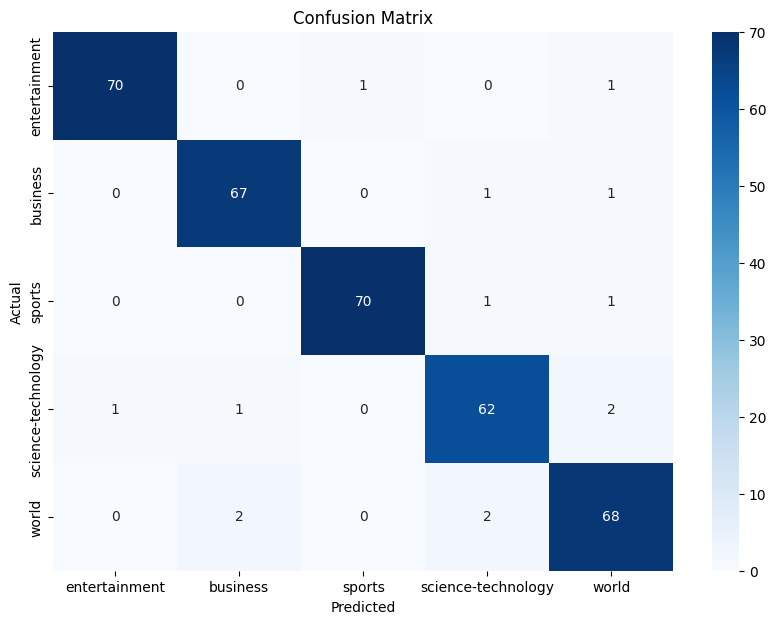

In [6]:
mnb = MultinomialNaiveBayes()
mnb.fit(X_train_tfidf, y_train_encoded)

y_pred = mnb.predict(X_test_tfidf)

accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print("\nClassification Report:\n")
print(classification_report(y_test_encoded, y_pred))

cm = confusion_matrix(y_test_encoded, y_pred)
num_classes = len(label_to_index) 

cm_df = pd.DataFrame(cm, 
                     index=[index_to_label[i] for i in range(num_classes)], 
                     columns=[index_to_label[i] for i in range(num_classes)])

plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

